Performs few-shot learning by prompting a GPT-2 Model

In [2]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
device = "cuda" if torch.cuda.is_available() else "cpu"

# Pre-Processing

In [3]:
max_length = 400

In [4]:
df = pd.read_csv('IMDB Dataset.csv')
df['sentiment'] = (df['sentiment'] == 'positive').astype(int)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
df['review'].apply(lambda x: len(x.split()))

0        307
1        162
2        166
3        138
4        230
        ... 
49995    194
49996    112
49997    230
49998    212
49999    129
Name: review, Length: 50000, dtype: int64

average word count: 231.15694


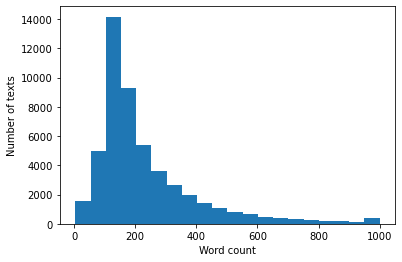

In [6]:
plt.hist(df['review'].apply(lambda x: min(len(x.split()), 1000)), bins=20)
plt.ylabel("Number of texts")
plt.xlabel("Word count")
print(f"average word count: {np.mean(df['review'].apply(lambda x: len(x.split())))}")

In [7]:
# Do a train-val-test split 80%-10%-10%
X_train, X_test, y_train, y_test = train_test_split(np.array(df['review']), np.array(df['sentiment']), test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

# GPT2 Fine Tuning

In [13]:
# load　GPT, BERT and support materials from huggingface
# requires pip install transformers
# if in jupyter notebook see here and you get an error mention ipython widgets see here: 
# https://stackoverflow.com/questions/53247985/tqdm-4-28-1-in-jupyter-notebook-intprogress-not-found-please-update-jupyter-an
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments

In [14]:
# Download the models
# Documentation for GPT: https://huggingface.co/transformers/model_doc/gpt2.html#gpt2lmheadmodel
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# Define a dataset class for language model fine-tuning, it's a generator so we don't have to store the entire dataset in memory
class GPT2Dataset(torch.utils.data.Dataset):
    def __init__(self, txt_list, tokenizer, max_length=max_length):
        # Encode all the text, padding and truncuating it along with adding attention masks to get the sequence length the same across all samples
        encodings_dict = tokenizer.batch_encode_plus(txt_list, truncation=True, max_length=max_length, padding="max_length")
        self.input_ids = encodings_dict['input_ids']
        self.attn_masks = encodings_dict['attention_mask']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return_dict = {"input_ids": torch.tensor(self.input_ids[idx]),
                       "attention_mask": torch.tensor(self.attn_masks[idx]), 
                       "labels": torch.tensor(self.input_ids[idx])} 
        return return_dict

In [10]:
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
train_dataset = GPT2Dataset(X_train, gpt_tokenizer)
val_dataset = GPT2Dataset(X_val, gpt_tokenizer)

Do fine tuning of the gpt_model using the hugging face out of the box trainer https://huggingface.co/transformers/custom_datasets.html#fine-tuning-with-trainerfrom

In [11]:
if os.path.exists("gpt_model.model"):
    gpt_model = torch.load("gpt_model.model")
else:
    training_args = TrainingArguments(
        output_dir='gpt_finetuning',     # output directory
        num_train_epochs=1,              # total number of training epochs (1 is enough to get very low perplexity and perplexity increases at 2)
        per_device_train_batch_size=4,  # batch size per device during training
        per_device_eval_batch_size=4,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.001,               # strength of weight decay
        logging_dir='gpt_finetuning_logs',            # directory for storing logs
        logging_steps=100,

        # Increase the betas as the batch size is quite small so updates are very stochastic
        adam_beta1=0.95, 
        adam_beta2=0.9995,
        learning_rate=1e-5
    )

    trainer = Trainer(
        model=gpt_model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=val_dataset             # evaluation dataset
    )

    trainer.train()

In [12]:
torch.save(gpt_model, "gpt_model.model")

# Testing Prompt Classification
Perform classification by adding the prompt "In summary the movie was" to the end of a review and classifying based on the probability of "Good" v.s. "Bad"

In [12]:
# create a new model class, takes a list of strings as input and outputs the binary classification probability p(good | review) / (p(good | review) + p(bad | review))
class gpt_prompt(torch.nn.Module):
    def __init__(self, gpt_model, tokenizer, prompt="in summary the movie was", pos_token="good", neg_token="bad"):
        super().__init__()
        self.gpt = gpt_model.to(device)
        self.tokenizer = tokenizer
        self.prompt = prompt
        self.prompt_length = len(tokenizer.encode(prompt))
        self.pos_token = tokenizer.encode(pos_token)[0]
        self.neg_token = tokenizer.encode(neg_token)[0]
        
    def forward(self, sentences):
        # Loop through and add prompts to the sentences, then perform prediction
        preds = []
        for string in sentences:
            length = len(self.tokenizer.encode(string))
            if length + self.prompt_length <= max_length:
                encodings_dict = self.tokenizer.encode_plus(string + " " + self.prompt, truncation=True, max_length=max_length, padding="max_length")
                prompt_end_idx = length + self.prompt_length - 1
            else: # encode full sentence then replace the (truncated) end with the prompt
                encodings_dict = self.tokenizer.encode_plus(string, truncation=True, max_length=max_length, padding="max_length")
                encodings_dict["input_ids"][-self.prompt_length:] = self.tokenizer.encode(self.prompt)
                prompt_end_idx = max_length - 1
            preds.append(self.predict(encodings_dict, prompt_end_idx))
            # Tests
            # print(self.tokenizer.decode(encodings_dict["input_ids"]))
            #print(prompt_end_idx, self.tokenizer.decode(encodings_dict["input_ids"][prompt_end_idx]))
            assert self.tokenizer.decode(encodings_dict["input_ids"][prompt_end_idx]) != "<|endoftext|>", "Prompt_end_idx points to a padding token not the prompt"
        return preds
    
    # given an encoded sentence + prompt and the end of the prompt return binary classification probability
    def predict(self, encodings_dict, prompt_end_idx):
        input_ids = torch.tensor([encodings_dict["input_ids"]]).long().to(device)
        attn_mask = torch.tensor([encodings_dict["attention_mask"]]).long().to(device)
        word_preds = self.gpt(input_ids, attention_mask=attn_mask)["logits"][0, prompt_end_idx, :]
        word_preds = torch.nn.functional.softmax(word_preds, dim=0)
        return word_preds[self.pos_token]/(word_preds[self.pos_token] + word_preds[self.neg_token]), word_preds

In [13]:
prompted = gpt_prompt(gpt_model, gpt_tokenizer, prompt="All in all the movie was", pos_token="good", neg_token="bad")
prompted.eval()
pass

## An example
Here we view the model's prediction for the following positive review

In [17]:
review = """The unlikely duo of Zero Mostel and Harry Belafonte team up to give us some interesting performances and subject matter in The Angel Levine. 
It's one interesting twist on the themes from It's A Wonderful Life.<br /><br />Zero is married to Ida Kaminsky and the two of them belong to a special class of elderly Jewish poor in New York.
Mostel used to be a tailor and proud of his trade, but his back and arthritis have prevented him from working. Kaminsky is mostly bedridden. He's reduced to applying for welfare. 
In desperation like Jimmy Stewart, he cries out to God for some help.<br /><br />Now maybe if he had gotten someone like Henry Travers things might have worked out differently, 
but even Stewart had trouble accepting Travers. But Travers had one thing going for him, he was over 100 years off this mortal coil and all his ties to earthly things were gone.
God sent Mostel something quite different, the recently deceased Harry Belafonte who should have at least been given some basic training for angels before being given an assignment.<br /><br />Belafonte
hasn't accepted he's moved on from life, he's still got a lot of issues. He also has a wife, Gloria Foster, who doesn't know he's passed on, hit by a car right at the beginning of the film. 
You put his issues and Mostel's issues and you've got a good conflict, starting with the fact that Mostel can't believe in a black Jew named Levine.<br /><br />This was the farewell performance for 
Polish/Jewish actress Ida Kaminsky who got a nomination for Best Actress in The Shop on Main Street a few years back. The other prominent role here is that of Irish actor Milo O'Shea playing a nice 
Jewish doctor. Remembering O'Shea's brogue from The Verdict, I was really surprised to see and hear him carry off the part of the doctor.<br /><br />The Angel Levine raises some interesting and 
disturbing questions about faith and race in this society. It's brought to you by a stellar cast and of course created by acclaimed writer Bernard Malamud. Make sure to catch it when broadcast."""

In [18]:
len(gpt_tokenizer.encode(review))

474

In [19]:
with torch.no_grad():
    results = prompted.forward([review])
    result = results[0][1].cpu().numpy()
    r = list(np.argsort(result)[::-1][:100])
    print([gpt_tokenizer.decode([x]) for x in r])
    print("Positive likelihood:", results[0][0])

[' a', ' very', ' great', ' an', ' the', ' so', ' just', ' one', ' nice', ' really', ' pretty', ' like', ' interesting', ' good', ' quite', ' wonderful', ' about', ' not', ',', ' funny', ' also', ' kind', ' well', ' fun', ' his', ' brilliant', ' amazing', ' excellent', ' memorable', ' beautiful', ' hilarious', ' such', ' more', ' touching', ' rather', ' enjoyable', ' almost', ' that', ' all', ' entertaining', ' fascinating', ' impressive', ' another', ' probably', ' as', ' much', ' superb', ' truly', ' painful', ' lovely', ' perfect', ' too', ' remarkable', ' to', ' fantastic', ' in', ' this', ' extremely', ' amusing', ' going', ' full', ' worth', ' somewhat', ' what', ' especially', ' done', ' surreal', ' way', ' only', ' something', ' fairly', ' better', ' delightful', ' enough', ' awesome', ' made', ' her', ' simply', ' even', ' pure', ' moving', ' bad', ' hard', ' mostly', ' actually', ' some', ' supposed', ' fine', ' no', ' particularly', ' incredible', ' meant', ' exciting', ' in

We can see the most likely words (near the start of the list)  are positive e.g. "great", "excellent", "good". Whereas negative words such as "mediocre" and "boring" are much lower

In [20]:
torch.cuda.empty_cache()

## Accuracy evaluation and threshold tuning
Here we find the optimal prediction threshold, as our positive token good has a higher base chance of appearing than bad which means with a threshold of 0.5 the model tends to predict all samples as positive

In [21]:
def predict(data):
    with torch.no_grad():
        preds = prompted.forward(data)
        preds = list(zip(*preds))[0]
        preds = torch.tensor(preds).cpu().numpy()
    return preds

In [22]:
prompted.eval()
print("Test set accuracy before tuning: {}".format(accuracy_score(y_test, predict(X_test) > 0.5)))

Token indices sequence length is longer than the specified maximum sequence length for this model (1076 > 1024). Running this sequence through the model will result in indexing errors


Test set accuracy before tuning: 0.6324


In [23]:
preds = predict(X_val)
thresholds = np.arange(0, 1, 0.01)
accuracies = []
for t in thresholds:
    binary_preds = preds > t
    accuracies.append(accuracy_score(y_val, binary_preds))

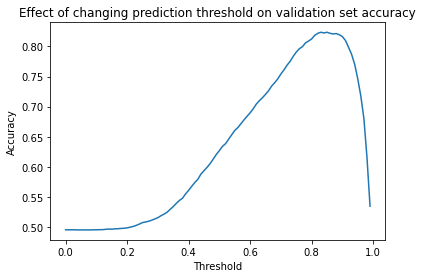

In [24]:
plt.plot(thresholds, accuracies)
plt.title("Effect of changing prediction threshold on validation set accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Threshold")
plt.show()

In [25]:
best_threshold = thresholds[np.argmax(accuracies)]
print("Best threshold: {}".format(best_threshold))

Best threshold: 0.8300000000000001


In [26]:
prompted.eval()
print("Test set accuracy with threshold tuning (requiring {} labelled samples): {}".format(len(X_val), accuracy_score(y_test, predict(X_test) > best_threshold)))

Test set accuracy with threshold tuning (requiring 5000 labelled samples): 0.8224


# Few Shot Learning
Now we see the effect of training the prompted model using only a few labelled samples (e.g. 20), not the entire validation set to tune the threshold

In [27]:
# sample a few training examples
n_samples = 20
fine_tune_idx = np.random.choice(len(X_train), size=n_samples)
fine_tune_x = X_train[fine_tune_idx]
fine_tune_y = torch.tensor(y_train[fine_tune_idx]).float().to(device)

optimizer = torch.optim.Adam(prompted.parameters(), lr=1e-5, betas=(0.95, 0.9995))
loss_func = torch.nn.BCELoss()

for epoch in range(10):  
    prompted.train()
    for i in range(len(fine_tune_x)):
        prompted.zero_grad()
        preds = prompted(fine_tune_x[i:i+1])
        loss = loss_func(preds[0][0], fine_tune_y[i])
        loss.backward()
        optimizer.step()
        
    prompted.eval()
    accuracy = accuracy_score(y_val[:100], predict(X_val[:100]) > 0.5)
    print("Epoch {} Train Loss: {} Validation Accuracy: {}".format(epoch, loss, accuracy))

Epoch 0 Train Loss: 0.6975820660591125 Validation Accuracy: 0.79
Epoch 1 Train Loss: 0.002826210344210267 Validation Accuracy: 0.8
Epoch 2 Train Loss: 0.004467617720365524 Validation Accuracy: 0.82
Epoch 3 Train Loss: 0.0010386136127635837 Validation Accuracy: 0.84
Epoch 4 Train Loss: 0.0007217149832285941 Validation Accuracy: 0.84
Epoch 5 Train Loss: 0.0003348553436808288 Validation Accuracy: 0.84
Epoch 6 Train Loss: 0.0005014603957533836 Validation Accuracy: 0.85
Epoch 7 Train Loss: 0.0003245403349865228 Validation Accuracy: 0.85
Epoch 8 Train Loss: 0.00043502970947884023 Validation Accuracy: 0.86
Epoch 9 Train Loss: 0.00023206780315376818 Validation Accuracy: 0.85


In [28]:
prompted.eval()
print("Test set accuracy with few shot learning (requiring {} labelled samples): {}".format(n_samples, accuracy_score(y_test, predict(X_test) > 0.5)))

Test set accuracy with few shot learning (requiring 20 labelled samples): 0.8998


# P-tuning
Implement a method of continuous prompt tuning from (https://github.com/THUDM/P-tuning) and test its results

In [8]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

In [9]:
# Class Plan:
# take in the length of the prompt
# create an embedding layer for that many tokens
# create an LSTM and MLP to process the prompt 
# How to feed the embedding to BERT
    # Get the embedding layer using https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#transformers.BertModel.get_input_embeddings 
    # Then directly pass embedding to BERT using self.bert(input_embeds=, attention_mask=)
# add prompting logic to the tokenizer function
    # it needs to first pass all tokens through LSTM and MLP
    # then add them into the sentence as needed
class BERTPrompt(torch.nn.Module):
    def __init__(self, bert, tokenizer, max_length=512, prompt_length=5):
        super().__init__()
        self.hidden_size = 768
        self.max_length = max_length
        self.prompt_length = prompt_length
        
        self.bert = bert.cuda()
        self.tokenizer = tokenizer
        self.bert_embedding = self.bert.get_input_embeddings()
        self.linear = torch.nn.Linear(self.hidden_size, 1).cuda()
        self.act = torch.nn.Sigmoid() 
        
        # p tuning modules
        self.prompt_embedding = torch.nn.Embedding(prompt_length, self.hidden_size).cuda()
        self.lstm_head = torch.nn.LSTM(input_size=self.hidden_size, hidden_size=int(self.hidden_size/2),
            num_layers=2, bidirectional=True, batch_first=True).cuda() # takes (batch_size, sequence length, hidden_size)
        self.mlp_head = torch.nn.Sequential(torch.nn.Linear(self.hidden_size, self.hidden_size),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(self.hidden_size, self.hidden_size)).cuda()
        
    # calls the tokenize function to get input embeddings, then passes them through bert
    def forward(self, input_sents):
        embeds = torch.zeros(len(input_sents), self.max_length, self.hidden_size).cuda()
        att_mask = torch.zeros(len(input_sents), self.max_length).cuda().long()
        for i, sent in enumerate(input_sents):
            embeds[i, :, :], att_mask[i, :] = self.tokenize(sent)
        
        _, cls_out = self.bert(inputs_embeds=embeds, attention_mask=att_mask)
        logits = self.linear(cls_out)
        return self.act(logits)
    
    # a tokenize function that embeds the sentence adds the prompt to the end and returns token embeddings along with attention mask
    def tokenize(self, input_sent):
        # generate prompt tokens from embedding
        prompt_tokens = self.prompt_embedding(torch.arange(self.prompt_length).cuda())
        prompt_tokens = torch.unsqueeze(prompt_tokens, 0) # add a batch dimension
        prompt_tokens, _ = self.lstm_head(prompt_tokens)
        prompt_tokens = self.mlp_head(prompt_tokens)[0]
        
        # Encode the input_sentence
        encoding_dict = self.tokenizer.encode_plus(input_sent, truncation=True, max_length=self.max_length, padding="max_length")
        sep_pos = encoding_dict["input_ids"].index(102) # the location of the [SEP] token is at the end of the input
        token_embeds = self.bert_embedding(torch.tensor(encoding_dict["input_ids"]).cuda())
        
        # Add the prompt tokens to the end and modify the att_mask to include the prompt
        start_prompt_pos = min(sep_pos, self.max_length - self.prompt_length - 1) # if the sentence is truncutated we must further truncate it to fit in the prompt
        end_prompt_pos = start_prompt_pos + self.prompt_length + 1
        token_embeds[start_prompt_pos:end_prompt_pos, :] = torch.cat([prompt_tokens, token_embeds[sep_pos:sep_pos+1, :]], dim=0)
        att_mask = encoding_dict["attention_mask"]
        att_mask[start_prompt_pos:end_prompt_pos] = [1]*(self.prompt_length+1)
        att_mask = torch.tensor(att_mask).cuda()
        
        return token_embeds, att_mask

In [10]:
pBERT = BERTPrompt(bert, tokenizer, prompt_length=5)
pBERT.forward(["Hello there"])

tensor([[0.4832]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [11]:
# sample a few training examples
n_samples = 1000
fine_tune_idx = np.random.choice(len(X_train), size=n_samples)
fine_tune_x = X_train[fine_tune_idx]
fine_tune_y = torch.tensor(y_train[fine_tune_idx]).float().to(device)

optimizer = torch.optim.Adam(pBERT.parameters(), lr=1e-5, betas=(0.95, 0.9995))
loss_func = torch.nn.BCELoss()

for epoch in range(10):  
    pBERT.train()
    for i in range(len(fine_tune_x)):
        pBERT.zero_grad()
        preds = pBERT(fine_tune_x[i:i+1])
        loss = loss_func(preds[0][0], fine_tune_y[i])
        loss.backward()
        optimizer.step()
        
    pBERT.eval()
    with torch.no_grad():
        accuracy = accuracy_score(y_val[:100], pBERT.forward(X_val[:100]).cpu().numpy() > 0.5)
    print("Epoch {} Train Loss: {} Validation Accuracy: {}".format(epoch, loss, accuracy))

Epoch 0 Train Loss: 1.2669013738632202 Validation Accuracy: 0.5
Epoch 1 Train Loss: 1.0662970542907715 Validation Accuracy: 0.5
Epoch 2 Train Loss: 0.9416559934616089 Validation Accuracy: 0.5
Epoch 3 Train Loss: 0.640381932258606 Validation Accuracy: 0.5
Epoch 4 Train Loss: 0.5026525855064392 Validation Accuracy: 0.51
Epoch 5 Train Loss: 0.2008924037218094 Validation Accuracy: 0.49
Epoch 6 Train Loss: 0.19231173396110535 Validation Accuracy: 0.49
Epoch 7 Train Loss: 0.19236771762371063 Validation Accuracy: 0.49
Epoch 8 Train Loss: 0.14558613300323486 Validation Accuracy: 0.53
Epoch 9 Train Loss: 0.07228980958461761 Validation Accuracy: 0.49


In [16]:
pBERT.forward(X_val[:3])

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED